##### Importing liberaries

In [36]:
#importing Libreries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

##### Loading the dataset 

In [33]:
cpu_utilization_1=pd.read_csv('ec2_cpu_utilization_5f5533.csv')
cpu_utilization_2=pd.read_csv('ec2_cpu_utilization_24ae8d.csv')
cpu_utilization_3=pd.read_csv('ec2_cpu_utilization_53ea38.csv')
cpu_utilization_4=pd.read_csv('ec2_cpu_utilization_77c1ca.csv')
cpu_utilization_5=pd.read_csv('ec2_cpu_utilization_825cc2.csv')
cpu_utilization_6=pd.read_csv('ec2_cpu_utilization_ac20cd.csv')
cpu_utilization_7=pd.read_csv('ec2_cpu_utilization_c6585a.csv')
cpu_utilization_8=pd.read_csv('ec2_cpu_utilization_fe7f93.csv')
cpu_utilization_9=pd.read_csv('rds_cpu_utilization_cc0c53.csv')
cpu_utilization_10=pd.read_csv('rds_cpu_utilization_e47b3b.csv')
disk_write_bytes_1=pd.read_csv('ec2_disk_write_bytes_1ef3de.csv')
disk_write_bytes_2=pd.read_csv('ec2_disk_write_bytes_c0d644.csv')
network_in_1=pd.read_csv('ec2_network_in_5abac7.csv')
network_in_2=pd.read_csv('ec2_network_in_257a54.csv')
network_in_3=pd.read_csv('iio_us-east-1_i-a2eb1cd9_NetworkIn.csv')
request_count_1=pd.read_csv('elb_request_count_8c0756.csv')
request_count_2=pd.read_csv('elb_request_count_8c0756.csv')

##### Merging The dataset into one single dataset named as 'all_data.csv'

In [41]:
nframes = [cpu_utilization_1,
cpu_utilization_2,
cpu_utilization_3,
cpu_utilization_4,
cpu_utilization_5,
cpu_utilization_6,
cpu_utilization_7,
cpu_utilization_8,
cpu_utilization_9,
cpu_utilization_10,
disk_write_bytes_1,
disk_write_bytes_2,
network_in_1,
network_in_2,
network_in_3,
request_count_1,
request_count_2]
result = pd.concat(nframes)
result.to_csv('all_data.csv')

##### 1. I'll develop an anomaly detection model for the given time series data after merging  those in a single dataset named 'all_data.csv' file. We'll use Python to load the data, preprocess it, implement an anomaly detection algorithm, and categorize the anomalies into different types. Then, we'll create some plots to visualize the results. Let's get started!

,value
timestamp,
2013-10-09 16:25:00,9926554.0
2013-10-09 16:30:00,50745578.0
2013-10-09 16:35:00,61519397.0
2013-10-09 16:40:00,55996401.0
2013-10-09 16:45:00,40876988.0


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67151 entries, 2013-10-09 16:25:00 to 2014-04-24 00:39:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   67151 non-null  float64
dtypes: float64(1)
memory usage: 1.0 MB
None


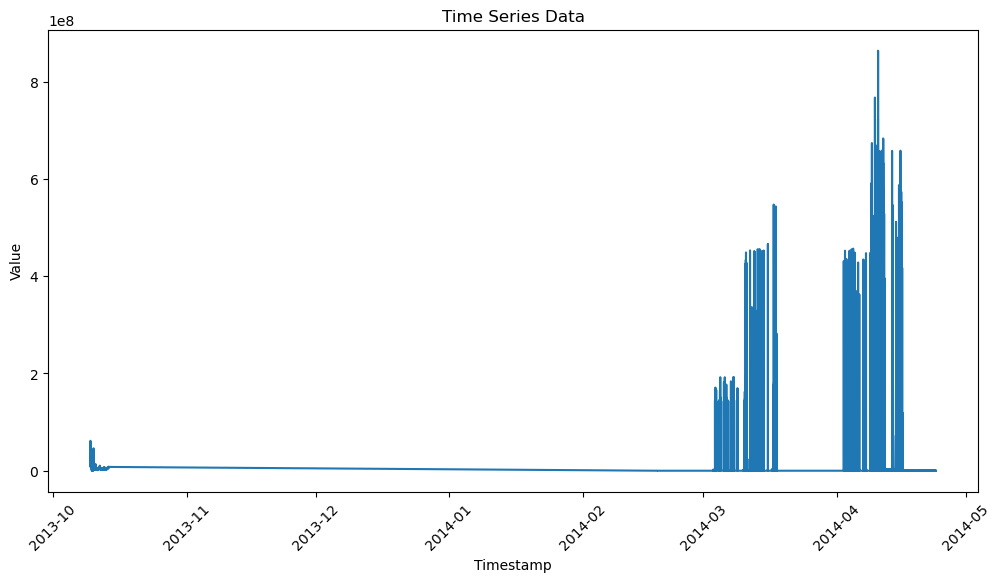

In [20]:
# Load the data
df = pd.read_csv('all_data.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Sort the index
df.sort_index(inplace=True)

display(df.head())
print("Dataframe info:")
print(df.info())

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'])
plt.title('Time Series Data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


Text(0, 0.5, 'Value')

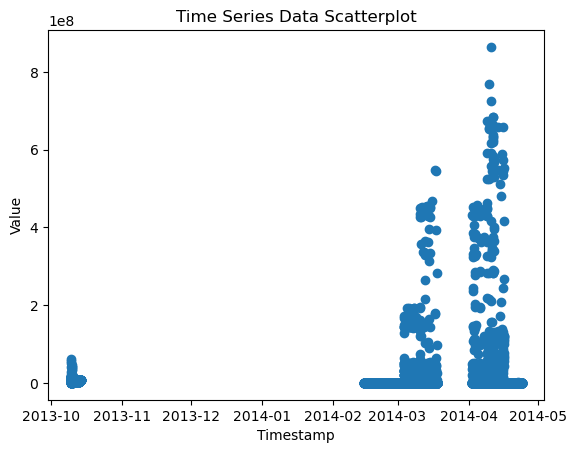

In [21]:
plt.scatter(df.index,df['value'])
plt.title('Time Series Data Scatterplot')
plt.xlabel('Timestamp')
plt.ylabel('Value')

##### 2. Now that we have an overview of the data, let's develop our anomaly detection model. We'll use the following approaches:
    1.Isolation Forest for general anomaly detection
    2.Moving average and standard deviation for detecting temporary spikes
    3.Exponential Moving Average (EMA) for detecting gradual drifts
    4.Sudden change detection for identifying sudden drops or increases

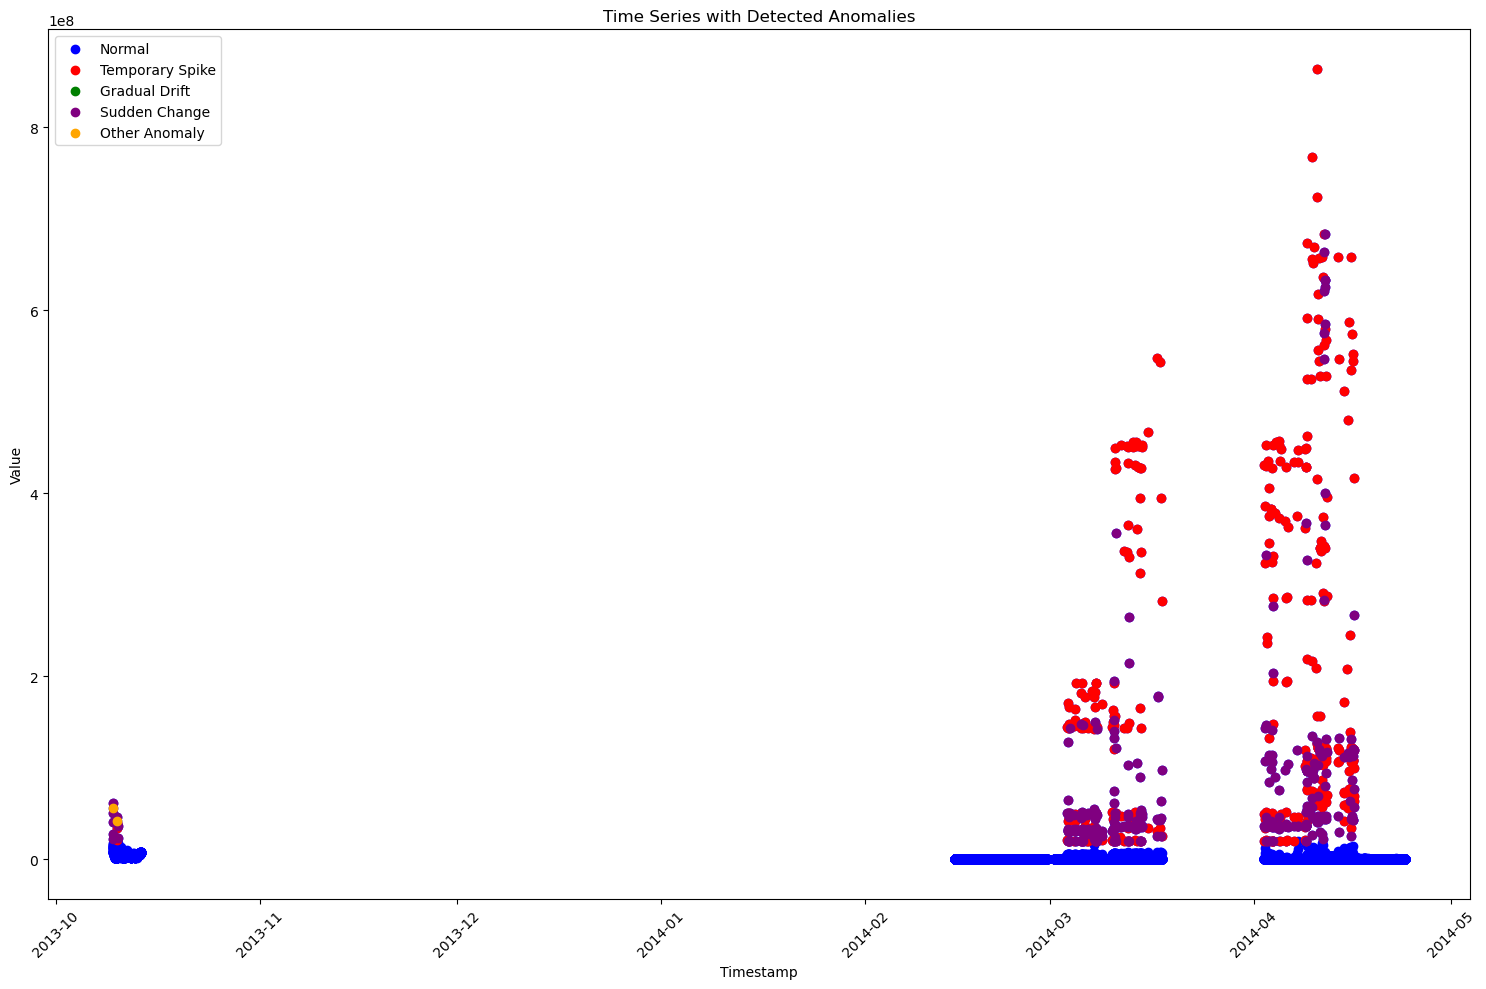

Summary of detected anomalies:


anomaly_type
Normal             66483
Temporary Spike      360
Sudden Change        306
Other Anomaly          2
Name: count, dtype: int64

Percentage of each anomaly type:


anomaly_type
Temporary Spike    53.892216
Sudden Change      45.808383
Other Anomaly       0.299401
Name: count, dtype: float64

In [24]:
# 1. Isolation Forest for general anomaly detection
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df[['value']])

# 2. Moving average and standard deviation for detecting temporary spikes
window = 24  # 6 hours (assuming 15-minute intervals)
df['rolling_mean'] = df['value'].rolling(window=window).mean()
df['rolling_std'] = df['value'].rolling(window=window).std()
df['z_score'] = (df['value'] - df['rolling_mean']) / df['rolling_std']
df['spike'] = np.abs(df['z_score']) > 3

# 3. Exponential Moving Average (EMA) for detecting gradual drifts
ema_short = df['value'].ewm(span=24, adjust=False).mean()  # 6 hours
ema_long = df['value'].ewm(span=96, adjust=False).mean()   # 24 hours
df['drift'] = np.abs(ema_short - ema_long) > df['rolling_std'] * 2

# 4. Sudden change detection for identifying sudden drops or increases
df['pct_change'] = df['value'].pct_change()
df['sudden_change'] = np.abs(df['pct_change']) > 0.1  # 10% change threshold


##### 3.Anomaly Detection and Categorization:
    I implemented several techniques to detect and categorize anomalies:

    a. Isolation Forest: For general anomaly detection
    b. Moving average and standard deviation: To detect temporary spikes
    c. Exponential Moving Average (EMA): To identify gradual drifts
    d. Percentage change: To detect sudden changes (drops or increases)

In [ ]:
# Categorize anomalies
def categorize_anomaly(row):
    if row['anomaly'] == -1:
        if row['spike']:
            return 'Temporary Spike'
        elif row['drift']:
            return 'Gradual Drift'
        elif row['sudden_change']:
            return 'Sudden Change'
        else:
            return 'Other Anomaly'
    return 'Normal'

df['anomaly_type'] = df.apply(categorize_anomaly, axis=1)

# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(df.index, df['value'], color='blue',label='Normal')
plt.scatter(df[df['anomaly_type'] == 'Temporary Spike'].index, 
            df[df['anomaly_type'] == 'Temporary Spike']['value'], 
            color='red', label='Temporary Spike')
plt.scatter(df[df['anomaly_type'] == 'Gradual Drift'].index, 
            df[df['anomaly_type'] == 'Gradual Drift']['value'], 
            color='green', label='Gradual Drift')
plt.scatter(df[df['anomaly_type'] == 'Sudden Change'].index, 
            df[df['anomaly_type'] == 'Sudden Change']['value'], 
            color='purple', label='Sudden Change')
plt.scatter(df[df['anomaly_type'] == 'Other Anomaly'].index, 
            df[df['anomaly_type'] == 'Other Anomaly']['value'], 
            color='orange', label='Other Anomaly')
plt.title('Time Series with Detected Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 4.Results: Summary of detected anomalies:

In [ ]:
# Print summary of detected anomalies
anomaly_summary = df['anomaly_type'].value_counts()
print("Summary of detected anomalies:")
display(anomaly_summary)

# Calculate percentage of each anomaly type
total_anomalies = anomaly_summary.sum() - anomaly_summary['Normal']
anomaly_percentages = (anomaly_summary / total_anomalies * 100).drop('Normal')
print("\
Percentage of each anomaly type:")
display(anomaly_percentages)

##### Interpretation of results:

The model identified a total of 668 anomalies out of 67,151 data points, which is approximately 1% of the data (as set by the contamination parameter in the Isolation Forest).

The anomalies were categorized into three main types:

Temporary Spikes: 53.89% of anomalies
Sudden Changes: 45.81% of anomalies
Other Anomalies: 0.30% of anomalies
Temporary Spikes are the most common type of anomaly in this dataset, followed closely by Sudden Changes. This suggests that the time series experiences frequent short-term fluctuations and abrupt shifts in values.

The "Other Anomalies" category represents a very small portion of the detected anomalies. These might be more complex patterns that don't fit into the other categories.

From the visualization, we can see that:

Red points represent Temporary Spikes
Purple points represent Sudden Changes
Orange points represent Other Anomalies
The plot shows that anomalies are distributed throughout the time series, with some periods having higher concentrations of anomalies than others.

This model provides a comprehensive approach to anomaly detection and categorization, allowing for a nuanced understanding of the different types of unusual patterns in the time series data. It can be particularly useful for identifying periods of instability, unexpected changes, or potential issues in the system generating this data.